In [47]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, BatchNormalization, Dropout, Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pedro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [48]:
# Load data
data = pd.read_csv('dataset/emotion_sentimen_dataset.csv')



In [49]:
data['Emotion'].value_counts()

Emotion
neutral       674538
love           39553
happiness      27175
sadness        17481
relief         16729
hate           15267
anger          12336
fun            10075
enthusiasm      9304
surprise        6954
empty           5542
worry           4475
boredom          126
Name: count, dtype: int64

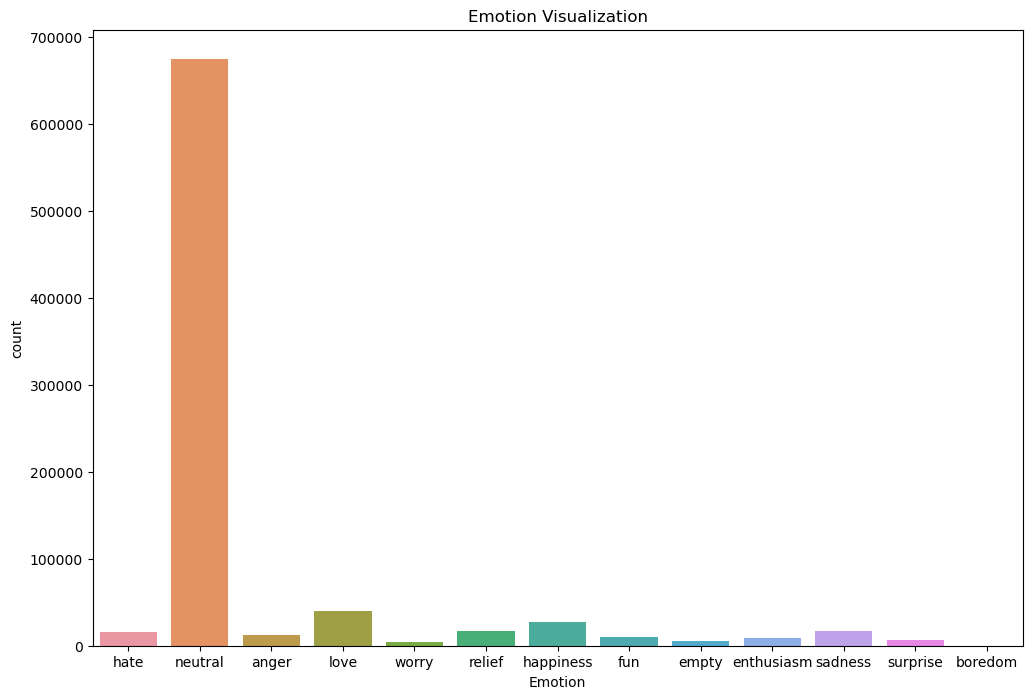

In [50]:
plt.figure(figsize=(12, 8))
sns.countplot(x='Emotion', data=data)
plt.title('Emotion Visualization')
plt.show()

In [51]:
def clean_data(text):
    # Convert all letters to lowercase
    text = text.lower()

    # Remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\d+', ' ', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in word_tokenize(text) if word not in stop_words])

    return text


# Clean the text data
data['text'] = data['text'].apply(clean_data)


In [52]:
print(data)

        Unnamed: 0                                               text  Emotion
0                0  seriously hate one subject death feel reluctan...     hate
1                1                         im full life feel appalled  neutral
2                2  sit write start dig feelings think afraid acce...  neutral
3                3  ive really angry r feel like idiot trusting fi...    anger
4                4  feel suspicious one outside like rapture happe...  neutral
...            ...                                                ...      ...
839550      839550  feel like telling horny devils find site suite...  neutral
839551      839551  began realize feeling agitated restless would ...  neutral
839552      839552  feel curious previous early dawn time seek tro...  neutral
839553      839553  feel becuase tyranical nature government el sa...  neutral
839554      839554  think spent time investigating surroundings th...  neutral

[839555 rows x 3 columns]


In [53]:
label_mapping = {'hate':0, 'neutral':1, 'anger':2, 'love':3, 'worry':4, 'relief':5, 'happiness':6,
       'fun':7, 'empty':8, 'enthusiasm':9, 'sadness':10, 'surprise':11, 'boredom':12}


data['Emotion'] = data['Emotion'].map(label_mapping)

In [54]:

tokenizer = Tokenizer(num_words=5000)

tokenizer.fit_on_texts(data['text'])
sequences = tokenizer.texts_to_sequences(data['text'])
maxlen = max(len(tokens) for tokens in sequences)
x = pad_sequences(sequences, maxlen=maxlen, padding='post')


encoder = LabelEncoder()
encoder.fit(data['Emotion'])
encoded_y = encoder.transform(data['Emotion'])
y = to_categorical(encoded_y)


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

input_size = np.max(x_train) + 1

In [57]:
# Define model
model = Sequential()
model.add(Embedding(input_dim=input_size, output_dim=100,input_shape=(69,)))
model.add(Bidirectional(LSTM(128)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(13, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=32)

Epoch 1/20
20989/20989 ━━━━━━━━━━━━━━━━━━━━ 637s 30ms/step - accuracy: 0.9571 - loss: 0.2086 - val_accuracy: 0.9936 - val_loss: 0.0607
Epoch 2/20
20989/20989 ━━━━━━━━━━━━━━━━━━━━ 627s 30ms/step - accuracy: 0.9925 - loss: 0.0570 - val_accuracy: 0.9940 - val_loss: 0.0525
Epoch 3/20
20989/20989 ━━━━━━━━━━━━━━━━━━━━ 644s 31ms/step - accuracy: 0.9928 - loss: 0.0521 - val_accuracy: 0.9939 - val_loss: 0.0502
Epoch 4/20
20989/20989 ━━━━━━━━━━━━━━━━━━━━ 674s 32ms/step - accuracy: 0.9931 - loss: 0.0484 - val_accuracy: 0.1748 - val_loss: 11.1428
Epoch 5/20
20989/20989 ━━━━━━━━━━━━━━━━━━━━ 726s 35ms/step - accuracy: 0.9932 - loss: 0.0461 - val_accuracy: 0.9940 - val_loss: 0.0475
Epoch 6/20
20989/20989 ━━━━━━━━━━━━━━━━━━━━ 804s 38ms/step - accuracy: 0.9930 - loss: 0.0453 - val_accuracy: 0.9941 - val_loss: 0.0467
Epoch 7/20
20989/20989 ━━━━━━━━━━━━━━━━━━━━ 801s 38ms/step - accuracy: 0.9933 - loss: 0.0436 - val_accuracy: 0.9941 - val_loss: 0.0469
Epoch 8/20
20989/20989 ━━━━━━━━━━━━━━━━━━━━ 856s 41ms/

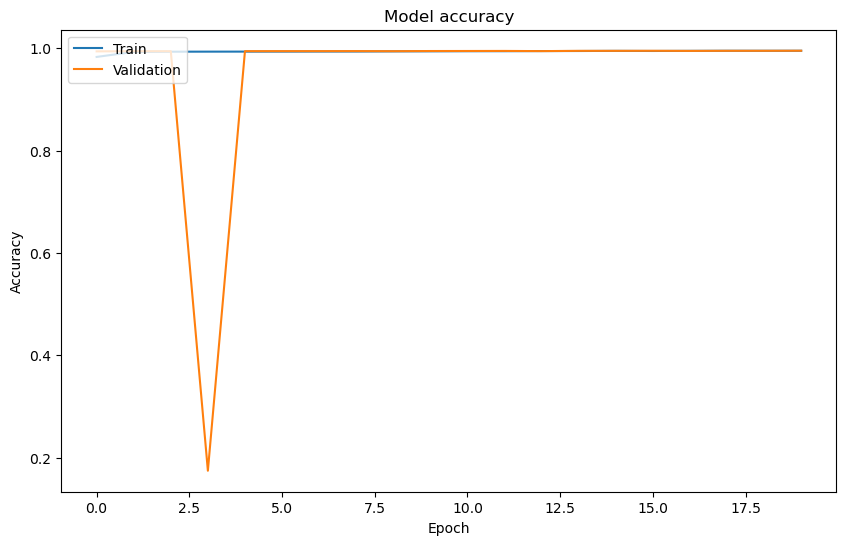

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

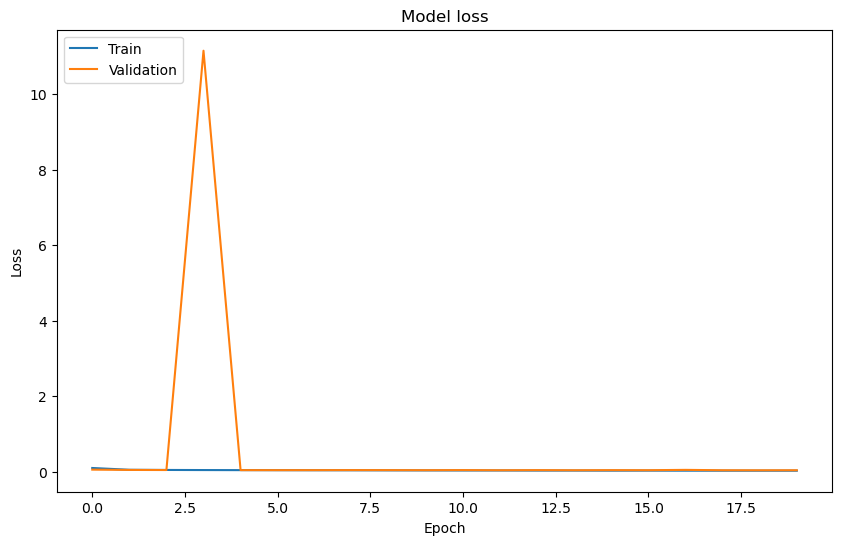

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [61]:
best_epoch = np.argmin(history.history['val_loss'])
print(f'Best epoch: {best_epoch + 1}')

Best epoch: 19


In [62]:
y_pred = model.predict(x_test)


5248/5248 ━━━━━━━━━━━━━━━━━━━━ 51s 10ms/step


In [63]:
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

In [65]:

f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 score: {f1:.4f}')


accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')


print('Classification Report:')
print(classification_report(y_true, y_pred))

F1 score: 0.9948
Accuracy: 0.9949
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2997
           1       0.99      1.00      1.00    135066
           2       1.00      0.96      0.98      2495
           3       1.00      0.99      0.99      7872
           4       1.00      0.99      1.00       879
           5       0.99      0.96      0.97      3231
           6       0.99      0.99      0.99      5458
           7       0.99      0.92      0.96      1987
           8       1.00      0.97      0.98      1151
           9       1.00      0.98      0.99      1849
          10       1.00      0.97      0.99      3465
          11       1.00      0.97      0.98      1434
          12       1.00      0.89      0.94        27

    accuracy                           0.99    167911
   macro avg       1.00      0.97      0.98    167911
weighted avg       0.99      0.99      0.99    167911



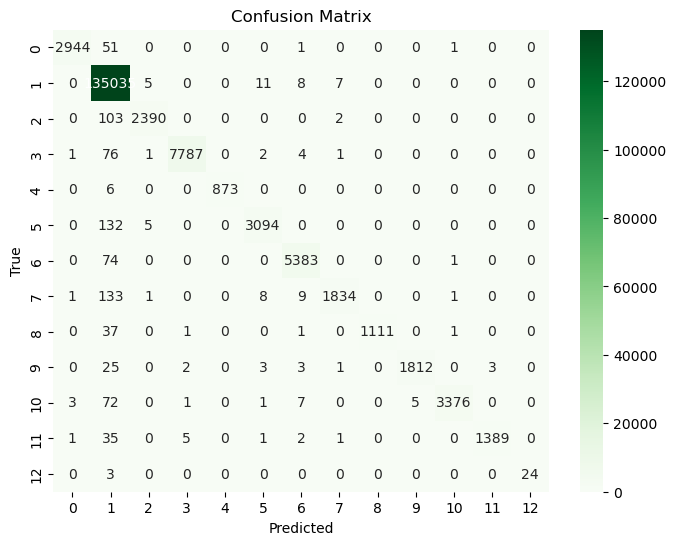

In [66]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [67]:
# Save the model
if not os.path.exists('model'):
    os.makedirs('model')


model.save('model/finalized_model.keras')

# Save the tokenizer and the encoder
with open('model/tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('model/encoder.pkl', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("The model, tokenizer, and encoder are successfully saved to the disk.")

The model, tokenizer, and encoder are successfully saved to the disk.
